In [1]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

In [2]:
plt.style.use('dark_background')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']
potential = (6600/28) #Per roof median potential kWh AC/yr https://insights.sustainability.google/places/ChIJOwV0Q_qxKIQR7NCkjDwfR-k/solar
dist = 1000 #Catchment area in sq m.

In [4]:
gdf_est = aqiGDL.gdf_from_db('puntos_pip','Estaciones')
#gdf_est = ox.project_gdf(gdf_est,to_crs='EPSG:32613')

In [6]:
gdf_est.head(1)

,Nombre,Latitud,Longitud,geometry
0,Mercado Municipal de Zapopan,20.722076,-103.391246,POINT (-103.39125 20.72208)


In [7]:
data = []
areas = {}
edges_data = []
for i in range(len(gdf_est)):
    x = gdf_est.at[i,'Longitud']
    y = gdf_est.at[i,'Latitud']
    est = gdf_est.at[i,'Nombre']
    point = (y, x)
    tags = {'building': True}
    gdf = ox.geometries_from_point(point, tags, dist=dist)
    gdf['Estacion'] = est
    # calculate the area in projected units (meters) of each building footprint
    gdf = ox.project_gdf(gdf)
    gdf['area'] = gdf.area
    gdf['kWh_year'] = gdf['area'] * potential
    data.append(gdf)
    areas[est] = gdf['area'].sum()
    G = ox.graph_from_point(point,dist=dist)
    edges = ox.graph_to_gdfs(G, nodes=False)
    edges['Estacion'] = est
    edges = ox.project_gdf(edges)
    edges_data.append(edges)
    G = None
    edges = None

In [8]:
df = pd.DataFrame(areas, index = ['area']).T
df['kWh_year'] = df['area'] * potential
gdf_est_ = ox.project_gdf(gdf_est)
gdf_est_ = gdf_est_.merge(df, right_index=True, left_on = 'Nombre')

In [9]:
gdf_ = pd.concat(data, ignore_index=True)
edges = pd.concat(edges_data, ignore_index=True)

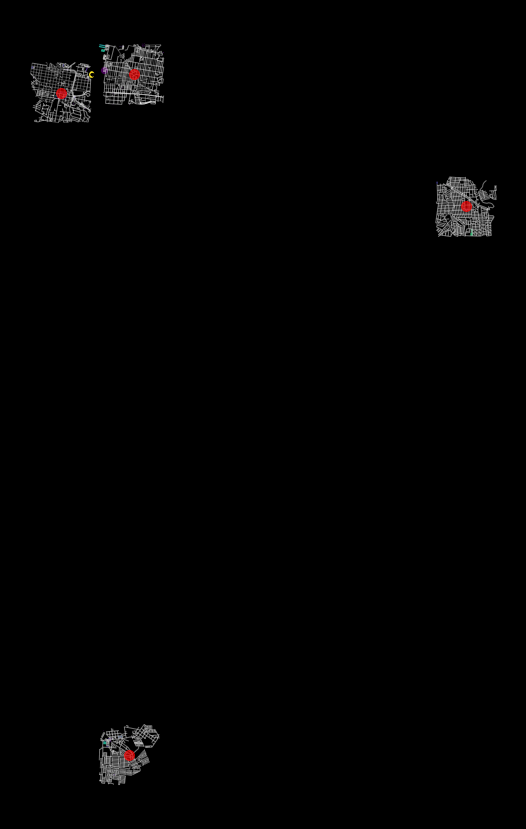

In [10]:
fig, ax = plt.subplots(1,1,figsize = (15,15))
gdf_.plot(ax=ax, column='area')
edges.plot(ax=ax, color='w', zorder=1, alpha=0.25, linewidth=1)
gdf_est_.plot(ax=ax, color='red', markersize=100, alpha=0.65, legend=False)
ax.axis('off')
plt.savefig('../output/figures/AreaEstudio.png',dpi=300,transparent=True)

In [11]:
gdf_.head(1)

,unique_id,osmid,element_type,nodes,amenity,building,name,geometry,religion,shop,...,name:es,type,wikidata,wikipedia,Estacion,area,kWh_year,note,sport,branch
0,way/158288130,158288130,way,"[1705161785, 1705161788, 1705161789, 170516178...",townhall,yes,Palacio Municipal de Zapopan,"POLYGON ((667646.561 2292175.764, 667653.861 2...",NaN,NaN,...,NaN,NaN,NaN,NaN,Mercado Municipal de Zapopan,2629.265098,619755.344498,NaN,NaN,NaN


In [12]:
gdf_est_.sort_values('kWh_year',ascending=False,inplace=True)

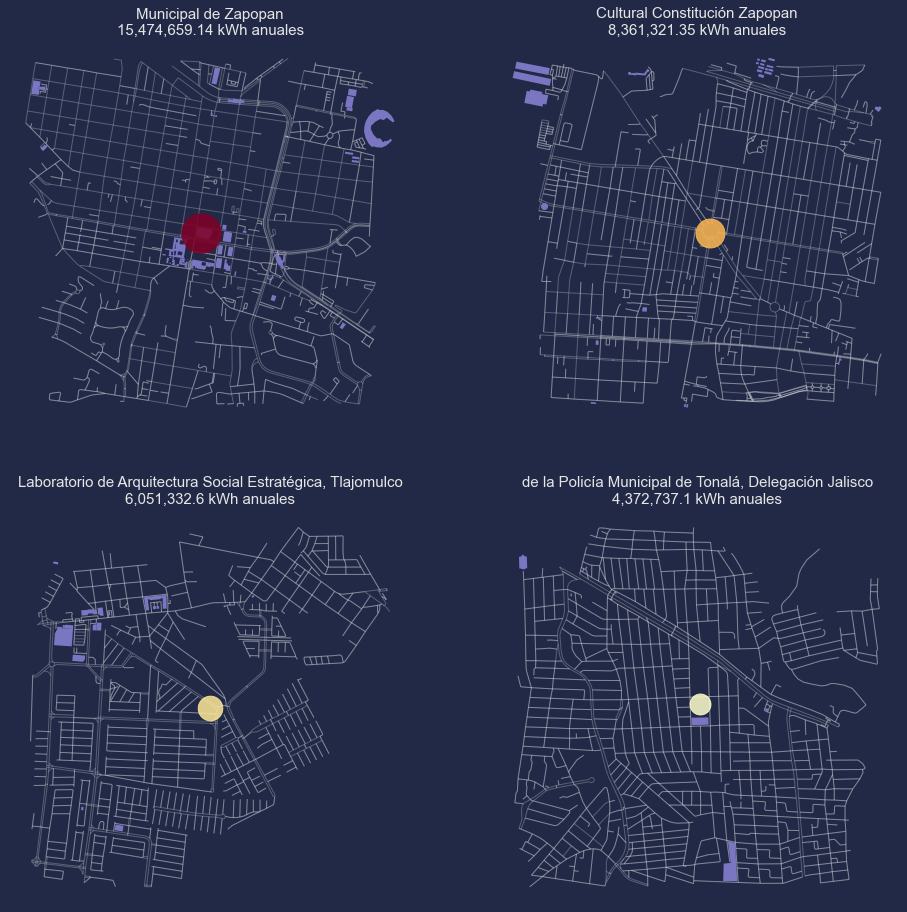

In [16]:
fig, axes = plt.subplots(2,2,figsize = (16,16))
for i, ax in zip(gdf_est_.index.tolist(), axes.flatten()):
    est = gdf_est.at[i,'Nombre']
    gdf_[gdf_['Estacion'] == est].plot(ax=ax, color='#7A76C2', zorder=2)
    edges[edges['Estacion'] == est].plot(ax=ax, color='w', zorder=1, alpha=0.25, linewidth=1)
    gdf_est_[gdf_est_['Nombre'] == est].plot(ax=ax, column ='kWh_year', cmap='YlOrRd', markersize=gdf_est_[gdf_est_['Nombre'] == est]['kWh_year']/10000, alpha=0.85, zorder=3, vmin=gdf_est_['kWh_year'].min(), vmax=gdf_est_['kWh_year'].max())
    ax.set_title('{}\n{:,} kWh anuales'.format(est.split(' ',maxsplit=1)[1], round(gdf_est_[gdf_est_['Nombre'] == est]['kWh_year'].values[0],2)), fontsize=15)
    ax.axis('off')
for ax in axes.flatten()[46:]:
    ax.set_visible(False)
#plt.savefig('../output/figures/potencial_solar/PotencialEstaciones_Mapa.png',dpi=300)

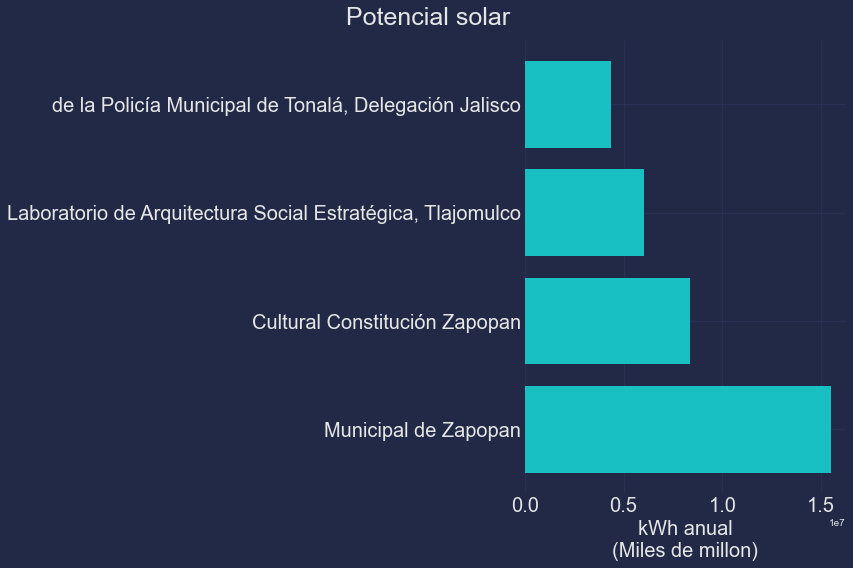

In [21]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.barh(gdf_est_['Nombre'].apply(lambda x: x.split(' ',maxsplit=1)[1]), gdf_est_['kWh_year'])
ax.set_xlabel('kWh anual\n(Miles de millon)',fontsize=20)
ax.tick_params(labelsize=20)
fig.suptitle('Potencial solar',fontsize=25)
fig.tight_layout()
#plt.savefig('../output/figures/potencial_solar/PotencialEstaciones.png',dpi=300)